In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.append('../src')
from utils.get_prices import get_prices
from utils.load_bucket_prices import load_bucket_prices
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import clear_output
sns.set_theme()


DATA_PATH = Path('../data')
DATA_PATH_BASKETS = DATA_PATH / 'baskets'
DATA_PATH_RAW = DATA_PATH / 'raw'
DATA_PATH_PROCESSED = DATA_PATH / 'processed'
OUTPUT_PATH = Path('../reports/charts')

In [2]:
def _shift_date(date_str, offset, unit='D'):
    date = pd.to_datetime(date_str)
    date += pd.to_timedelta(offset, unit=unit)
    return date.strftime('%Y-%m-%d')

with open('../tiingo_secrets.json') as f:
  api_key = json.load(f)['api_key']

basket = 'trading_cycle'
download_end = '2021-06-22'
download_start = _shift_date(download_end, -250*5, 'W')
prices = load_bucket_prices('../', download_start, download_end, 'tiingo', basket, api_key)['adj_close']
rtn_1d = prices.pct_change()
print(prices.shape)
prices.tail()

Found existing data file. Reading...
Data read from: ..\data\raw\prc_trading_cycle_1997-07-08_2021-06-22_tiingo.csv
(6030, 262)


symbols,AAL,AAPL,ABMD,ABNB,ABT,ADBE,ADI,AI,AIR,AJRD,...,WORK,XENT,XLNX,YELP,ZBH,ZEN,ZG,ZM,ZNGA,ZS
date,,,,,,,,,,,,,,,,,,,,,
2021-06-16 00:00:00+00:00,22.83,130.15,303.30,149.15,110.06,543.33,166.02,57.90,41.14,49.20,...,44.31,16.96,126.18,41.32,158.03,138.97,108.84,361.83,10.29,212.27
2021-06-17 00:00:00+00:00,22.23,131.79,312.61,150.70,111.63,551.36,166.22,59.90,40.51,48.86,...,44.50,16.73,132.34,40.88,160.39,144.44,113.66,372.95,10.58,215.14
2021-06-18 00:00:00+00:00,22.29,130.46,318.57,152.52,110.33,565.59,162.19,59.18,39.63,48.63,...,44.25,16.34,131.92,38.83,158.51,145.93,117.99,374.24,10.32,218.60
2021-06-21 00:00:00+00:00,22.45,132.30,325.09,149.70,111.44,567.35,164.15,57.89,40.41,48.16,...,44.57,16.22,127.53,39.20,163.48,146.07,113.84,369.25,10.48,216.41
2021-06-22 00:00:00+00:00,22.11,133.98,327.19,149.68,110.96,575.74,163.67,60.49,40.25,48.31,...,44.28,16.32,130.02,39.24,166.38,144.77,115.67,374.65,10.33,219.61


In [3]:
def _rolling_stats(prices, n_weeks):
    n_days = n_weeks * 5
    df = pd.DataFrame()
    df[f'ma_{n_weeks}'] = prices.rolling(n_days).mean()
    df[f'high_{n_weeks}'] = prices.rolling(n_days).max()
    df[f'low_{n_weeks}'] = prices.rolling(n_days).min()
    return df


def _relative_price_strength(df, ma_name):
    n_weeks = int(ma_name.split('_')[1])
    ma_bench = _rolling_stats(df['benchmark_price'], n_weeks)
    rtn_stock = df[ma_name].iloc[-1] / df[ma_name].iloc[-n_weeks*5 - 1] - 1
    rtn_bench = ma_bench[ma_name].iloc[-1] / ma_bench[ma_name].iloc[-n_weeks*5 - 1] - 1
    return rtn_stock / rtn_bench


def _ma_week_over_week_trend(ma):
    ma_past = ma.iloc[-6]
    ma_curr = ma.iloc[-1]
    if pd.isnull(ma_past) or pd.isnull(ma_curr):
        return ''
    if ma_past <= ma_curr:
        return 'Bullish'
    else:
        return 'Bearish'

    
def _price_vs_ma_trend(df, ma_name):
    last_price = df['price'].iloc[-1]
    last_ma = df[ma_name].iloc[-1]
    n_weeks = int(ma_name.split('_')[1])
    trend = _ma_week_over_week_trend(df[ma_name])    
    if (trend == 'Bullish' and last_price < last_ma or
        trend == 'Bearish' and last_price > last_ma):
        trend += ' at Risk'
    return trend


def _last_4w_high_low(df, ma_name):
    last_4w_high_idx = df[ma_name].tail(4*5).idxmax()
    last_4w_low_idx = df[ma_name].tail(4*5).idxmin()
    if last_4w_high_idx == df[ma_name].index[-1]:
        return 'High'
    elif last_4w_low_idx == df[ma_name].index[-1]:
        return 'Low'
    else:
        return ''
    

def calc_trend(prices, ticker, benchmark, n_weeks):
    p_tk = prices[ticker]
    p_bench = prices[benchmark]
    p_relative = p_tk / p_bench

    df = pd.DataFrame()
    df['price'] = p_tk
    df['benchmark_price'] = p_bench
    for n_week in n_weeks:
        df_stat = _rolling_stats(p_tk, n_week)
        df_stat_rela = _rolling_stats(p_relative, n_week)
        df_stat_rela.columns = df_stat_rela.columns + '_relative'
        df = pd.concat([df, df_stat, df_stat_rela], axis=1)

    # trends
    res = pd.DataFrame({
        'Ticker': ticker,
        'Price': df['price'].iloc[-1],
        'Industry': '',
        'Tactical Trend Relative Price Strength': _relative_price_strength(df, 'ma_40'),
        '52W Relative Price Strength': _relative_price_strength(df, 'ma_52'),
        '40W Trend': _price_vs_ma_trend(df, 'ma_40'),
        f'40W Trend vs {benchmark}': _price_vs_ma_trend(df, 'ma_40_relative'),
        '26W Trend': _price_vs_ma_trend(df, 'ma_26'),
        f'26W Trend vs {benchmark}': _price_vs_ma_trend(df, 'ma_26_relative'),
        '13W Trend': _price_vs_ma_trend(df, 'ma_13'),
        f'13W Trend vs {benchmark}': _price_vs_ma_trend(df, 'ma_13_relative'),
        '13W High/Low': _last_4w_high_low(df, 'ma_13'),
        f'13W High/Low vs {benchmark}': _last_4w_high_low(df, 'ma_13_relative'),
        '52W High/Low': _last_4w_high_low(df, 'ma_52'),
        f'52W High/Low vs {benchmark}': _last_4w_high_low(df, 'ma_52_relative'),
        '200W Trend': _price_vs_ma_trend(df, 'ma_200'),
        f'200W Trend vs {benchmark}': _price_vs_ma_trend(df, 'ma_200_relative'),
    }, index=[0])

    return res


def calc_trend_signals(prices, benchmark):
    n_weeks = [13, 26, 40, 52, 200] # in weeks
    df_list = []
    for tk in prices.columns:
        clear_output(wait=True)
        print("Calculating: " + tk)
        if tk != benchmark:
            df_list.append(calc_trend(prices, tk, benchmark, n_weeks))
    print("Done!")
    df = pd.concat(df_list, axis=0)
    df = df.sort_values('Tactical Trend Relative Price Strength', ascending=False)
    return df


In [8]:
df = calc_trend_signals(prices, benchmark='SPY')
df

Calculating: ZS
Done!


,Ticker,Price,Industry,Tactical Trend Relative Price Strength,52W Relative Price Strength,40W Trend,40W Trend vs SPY,26W Trend,26W Trend vs SPY,13W Trend,13W Trend vs SPY,13W High/Low,13W High/Low vs SPY,52W High/Low,52W High/Low vs SPY,200W Trend,200W Trend vs SPY
0,NIO,44.10,,22.756805,40.526835,Bullish,Bullish,Bullish at Risk,Bearish at Risk,Bullish,Bearish at Risk,,Low,High,High,,
0,SPWR,25.51,,15.076280,10.374060,Bullish at Risk,Bullish,Bullish at Risk,Bullish,Bearish,Bearish at Risk,Low,Low,High,High,Bullish,Bullish
0,FVRR,230.99,,12.041778,NaN,Bullish,Bullish,Bullish,Bearish at Risk,Bearish at Risk,Bearish at Risk,,Low,High,High,,
0,TSLA,623.71,,9.976209,20.056951,Bullish,Bullish,Bearish,Bearish at Risk,Bearish,Bearish at Risk,Low,Low,High,High,Bullish,Bullish
0,NLS,15.64,,9.825305,21.995378,Bullish at Risk,Bearish at Risk,Bearish,Bearish at Risk,Bearish,Bearish at Risk,Low,Low,High,High,Bearish at Risk,Bearish at Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NARI,96.60,,NaN,NaN,Bullish,Bearish at Risk,Bullish at Risk,Bullish,Bearish,Bearish at Risk,Low,Low,High,High,,
0,QS,27.36,,NaN,NaN,Bullish at Risk,Bullish,Bearish,Bearish at Risk,Bearish,Bearish at Risk,Low,Low,,,,
0,RXT,19.35,,NaN,NaN,Bearish,Bearish at Risk,Bearish,Bearish at Risk,Bearish,Bearish at Risk,Low,Low,,,,
0,SNOW,249.29,,NaN,NaN,,,Bearish,Bearish at Risk,Bullish,Bullish,High,,,,,


In [16]:
t0 = '2020-06-25'
prices_outsample = prices.loc[t0:, :]
rtn_1d_outsample = rtn_1d.loc[t0:, :]
cumrtn_outsample = (1 + rtn_1d_outsample).cumprod() - 1
df = calc_trend_signals(prices.loc[:t0, :], benchmark='SPY')



Calculating: ZS
Done!


In [39]:
selected = df.loc[(df[['40W Trend', '40W Trend vs SPY',
                       '26W Trend', '26W Trend vs SPY']] == 'Bullish').all(axis=1)]
selected = selected.loc[selected['Tactical Trend Relative Price Strength'].notna()].tail(10)
selected

,Ticker,Price,Industry,Tactical Trend Relative Price Strength,52W Relative Price Strength,40W Trend,40W Trend vs SPY,26W Trend,26W Trend vs SPY,13W Trend,13W Trend vs SPY,13W High/Low,13W High/Low vs SPY,52W High/Low,52W High/Low vs SPY,200W Trend,200W Trend vs SPY
0,VAPO,39.75,,-1.521561,NaN,Bullish,Bullish,Bullish,Bullish,Bullish,Bullish,High,High,High,High,,
0,DBX,22.16,,-1.580588,-2.040765,Bullish,Bullish,Bullish,Bullish,Bullish,Bearish at Risk,High,,Low,Low,,
0,CREE,58.40,,-1.585115,-0.077207,Bullish,Bullish,Bullish,Bullish,Bullish,Bullish,High,High,High,Low,Bullish,Bullish
0,W,205.12,,-2.158157,-1.049605,Bullish,Bullish,Bullish,Bullish,Bullish,Bullish,High,High,High,High,Bullish,Bullish
0,DOMO,31.65,,-3.538516,NaN,Bullish,Bullish,Bullish,Bullish,Bullish,Bullish,High,High,,,,
0,NEWR,69.50,,-3.650134,-3.261414,Bullish,Bullish,Bullish,Bullish,Bullish,Bullish,High,High,Low,Low,Bullish,Bullish
0,ABMD,241.75,,-3.886076,-4.288874,Bullish,Bullish,Bullish,Bullish,Bullish,Bullish,High,High,Low,Low,Bullish,Bullish
0,NIO,7.08,,-4.071299,NaN,Bullish,Bullish,Bullish,Bullish,Bullish,Bullish,High,High,High,High,,
0,NLS,8.56,,-4.652273,-7.113479,Bullish,Bullish,Bullish,Bullish,Bullish,Bullish,High,High,High,High,Bearish,Bearish at Risk
0,IRBT,82.15,,-4.666210,-3.723673,Bullish,Bullish,Bullish,Bullish,Bullish,Bullish,High,High,Low,Low,Bullish,Bullish


<AxesSubplot:xlabel='date'>

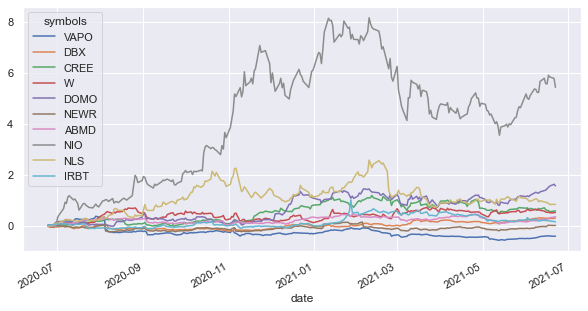

In [42]:
cumrtn_outsample.loc[:, selected['Ticker']].plot(figsize=(10, 5))

<AxesSubplot:xlabel='date'>

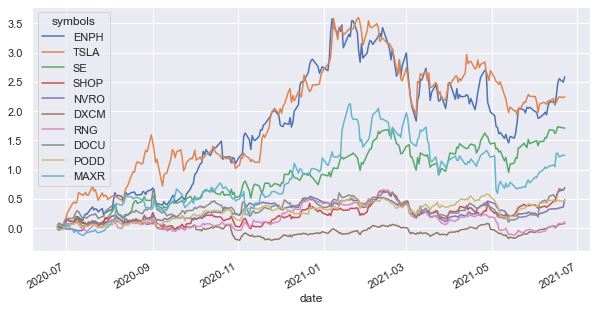

In [38]:

cumrtn_outsample.loc[:, selected['Ticker']].plot(figsize=(10, 5))

In [6]:
filename = basket + '.csv'
df.to_csv(DATA_PATH_PROCESSED / filename, index=False)